In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt 
import experiment as ex
from network_generation import generation as ng
from scipy import optimize
from scipy.odr import * 
   
def find_ER_nD(kappa, plot=False):
        
    # make sure this is a float!
    z0 = float(kappa/2)
    w1irange = np.arange(0,1,.01)
    w1o = lambda x: np.exp(-z0*np.exp(-z0*x))
    w1i = lambda y: -(1/z0)*np.log((1/z0)*np.log(1/y))

    if plot:
        plt.figure()
        plt.plot(w1irange,[w1o(i) for i in w1irange])
        plt.plot(w1irange,w1irange,'k-')
        
        w1o = lambda x: np.exp(-z0*np.exp(-z0*x))
    w1i = lambda y: -(1/z0)*np.log((1/z0)*np.log(1/y))
    
    # BABY NEWTON METHOD 
    xold = 0.5
    yold = 0.5
    check = 100
    while abs(check)>0.001:

        # move up
        ynew = w1o(xold)
        # move right 
        xnew = ynew
        
        if plot: 
            plt.plot((xold,xold),(yold,ynew),'r-')
            plt.plot((xold,xnew),(ynew,ynew),'r-')

        # compute check 
        check = xold - xnew 

        # update for next iteration
        xold = xnew 
        yold = ynew

    w1 = xnew 
    w2 = 1 - np.exp(-z0*w1)
    nD = w1 - w2 + z0*w1*(1-w2)

    return nD

# Ordinary Nonlinear Least Squares 

Here we want to explore the fitting of the curve to extract the scaling. We will play around with the nonlinear least squares routine in scipy to determine a good fit. 

(array([-0.40533452]), array([[  9.46807077e-05]]))


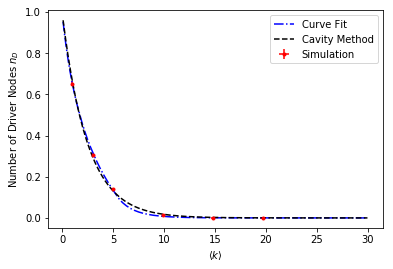

In [2]:
plt.figure(2)

# load and plot ER data 
kappa_range = [1,3,5,10,15,20]
n = 100

# ER SIMULATION
ERE = ex.ERExperiment(kappa_range, n)
plt.errorbar(ERE.mean_degree_list,ERE.mean_nD_list,fmt='ro',markersize=3,ecolor='r',xerr=ERE.std_degree_list,yerr=ERE.std_nD_list)

# ER THEORY
kappa_range = np.arange(.1,30,.01)
nD_list = []
for kappa in kappa_range:
    nD_list.append(find_ER_nD(kappa))
plt.plot(kappa_range,nD_list,'b-.')

# ER FITTING OLS 
popt = optimize.curve_fit(lambda t,b:np.exp(b*t), ERE.mean_degree_list, ERE.mean_nD_list)#,p0=(1,-0.5))#, sigma=ERE.std_nD_list,absolute_sigma=False)
print popt
plt.plot(kappa_range,np.exp(popt[0][0]*kappa_range),'k--')

plt.xlabel('$\\langle{k}\\rangle$')
plt.ylabel('Number of Driver Nodes $n_D$')
leg_str = ['Simulation','Cavity Method','Curve Fit']
plt.legend(leg_str[::-1])
# plt.xlim([5,20])
# plt.ylim([0,.2])

# residual 
plt.figure(4)
fit = [np.exp(k*output.beta[0]) for k in kappa_range]
res = np.abs(np.subtract(y,fit)) 
plt.errorbar(kappa_range,res,yerr=np.sqrt(output_full.res_var))
plt.xlabel('$\\langle{\\kappa}\\rangle$')
plt.ylabel('residual')

# Orthogonal Distance Regression

Here, we utilize Boggs's weighted ODR routine ported to scipy from fortran. We will compare the results to normal NLS 

100
[0.042056509603151805, 0.040892419835465842, 0.02947880594596735, 0.012346659467240522, 0.0087607077339676154, 0.0019595917942265427, 0.0]
(array([-0.4009738]), array([[  7.96304912e-05]]))


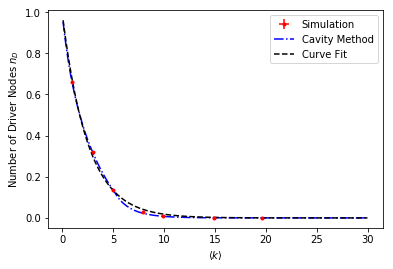

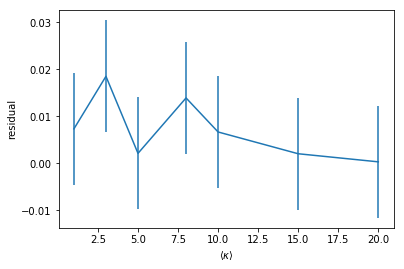

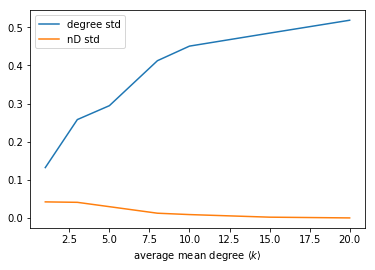

In [4]:
plt.figure(3)

### DATA ###
kappa_range = [1,3,5,8,10,15,20]
n = 100

ERE = ex.ERExperiment(kappa_range, n)
print ERE.ensembles[0].get_num_samples()
mean_degree_list, std_degree_list, stddev_degree_list = ERE.find_degree_stats()
mean_nD_list, std_nD_list, stddev_nD_list = ERE.find_nD_stats()

print stddev_nD_list

sim = plt.errorbar(mean_degree_list,mean_nD_list,fmt='ro',markersize=3,ecolor='r',xerr=std_degree_list,yerr=std_nD_list)

kappa_range_fine = np.arange(.1,30,.01)
nD_list = []
for kappa in kappa_range_fine:
    nD_list.append(find_ER_nD(kappa))
theory, = plt.plot(kappa_range_fine,nD_list,'b-.')

#### ODR ####

# first run OLS to get a guess # 
popt = optimize.curve_fit(lambda t,b:np.exp(b*t), mean_degree_list, mean_nD_list)#,p0=(1,-0.5))#, sigma=ERE.std_nD_list,absolute_sigma=False)
print popt

# MODEL
def f(B, x):
    return np.exp(B[0]*x)

x = mean_degree_list
y = mean_nD_list 
wx = [s+1 for s in std_degree_list]
wy = [s+1 for s in std_nD_list] 

exponential = Model(f)
data = Data(x, y, wd=wx, we=wy)
odr = ODR(data, exponential, beta0=popt[0])
output = odr.run()

fit, = plt.plot(kappa_range_fine,np.exp(output.beta[0]*kappa_range_fine),'k--')

thermo, = plt.plot(kappa_range,[np.exp(-kappa/2) for kappa in kappa_range])

plt.xlabel('$\\langle{k}\\rangle$')
plt.ylabel('Number of Driver Nodes $n_D$')
leg_str = ['Simulation','Cavity Method','ODR Fit','Asymptotic Scaling']
plt.legend([sim,theory,fit,thermo],leg_str)

# # residual 
# plt.figure(4)
# fit = [np.exp(k*output.beta[0]) for k in kappa_range]
# res = np.abs(np.subtract(y,fit)) 
# plt.errorbar(kappa_range,res,yerr=np.sqrt(output.res_var))
# plt.xlabel('$\\langle{\\kappa}\\rangle$')
# plt.ylabel('residual')

# # standard errors 
# plt.figure(5)
# ERdegstd, = plt.plot(kappa_range,stddev_degree_list)
# ERnDstd, = plt.plot(kappa_range,stddev_nD_list)
# plt.legend([ERdegstd, ERnDstd],['degree std','nD std'])
# plt.xlabel('average mean degree $\\langle{k}\\rangle$')

# Data Generation

In [9]:
# GENERATE RGG DATA 

import network_generation.generation as ng

kappa_range = [1,3,5,8,10,15,20]
n_range = [100]
d_range = [2,3,6,9,15,25]
boundaries = ['p']#['s','p','g']
num_samples = 100

print 'running ' + str(len(n_range)*len(d_range)*len(boundaries)*len(kappa_range)) + ' generations'
i=1

## RGGs ##
for kappa in kappa_range:
    for n in n_range:
        for d in d_range:
            for boundary in boundaries: 
                RGG = ng.RGGEnsemble(kappa, n, d, boundary=boundary, num_radii=10)
                RGG.generate_samples(n=num_samples)
                # data to disk 
                RGG.to_disk()
                print 'saved run ' + str(i)
                i+=1 

running 42 generations
saved run 1
saved run 2
saved run 3
saved run 4
saved run 5
saved run 6
saved run 7
saved run 8
saved run 9
saved run 10
saved run 11
saved run 12
saved run 13
saved run 14
saved run 15
saved run 16
saved run 17
saved run 18
saved run 19
saved run 20
saved run 21
saved run 22
saved run 23
saved run 24
saved run 25
saved run 26
saved run 27
saved run 28
saved run 29
saved run 30
saved run 31
saved run 32
saved run 33
saved run 34
saved run 35
saved run 36
saved run 37
saved run 38
saved run 39
saved run 40
saved run 41
saved run 42


In [9]:
# GENERATE ER DATA 
kappa_range = [1,3,5,8,10,15,20]
n_range = [1000]
num_samples = 100
print 'running ' + str(len(n_range)*len(kappa_range)) + ' generations'
i=1
for kappa in kappa_range:
    for n in n_range:
        # make an ER Ensemble
        ER = ng.EREnsemble(kappa,n)
        # generate samples 
        # sample data is stored in the object 
        ER.generate_samples(n=num_samples)
        # data to disk 
        ER.to_disk()
        print 'saved run ' + str(i)
        i+=1 

running 7 generations
saved run 1
saved run 2
saved run 3
saved run 4
saved run 5
saved run 6
saved run 7


## regression without LCC

In [ ]:
# set up plots and axes 
ndkfig = plt.figure(1)
ndkax = ndkfig.add_subplot(1,1,1)
gdfig = plt.figure(2)
gdax = gdfig.add_subplot(1,1,1)

# MODEL
def f(B, x):
    return np.exp(B[0]*x)

# params
kappa_range = [1,3,5,8,10,15,20]
kappa_range_fine = np.arange(.1,22,.01)
n = 1000
boundaries = ['s','p']
d_range = [2,3,6,9,15,25]

## ER 
gdhandles = []
ndkhandles = []
gdlegend = []
ndklegend = []

# ER data and fit
ERE = ex.ERExperiment(kappa_range, n)
# plt.errorbar(ERE.mean_degree_list,ERE.mean_nD_list,fmt='ro',markersize=3,ecolor='r',xerr=ERE.std_degree_list,yerr=ERE.std_nD_list)

mean_degree_list, std_degree_list, _ = ERE.find_degree_stats()
mean_nD_list, std_nD_list, _ = ERE.find_nD_stats()

x = mean_degree_list
y = mean_nD_list 
wx = [s+1 for s in std_degree_list]
wy = [s+1 for s in std_nD_list] 

# fitting 
# popt = optimize.curve_fit(lambda t,b:np.exp(b*t), RGG.mean_degree_list, RGG.mean_nD_list)
popt = [[-0.5]]
exponential = Model(f)
data = Data(x, y, wd=wx, we=wy)
odr = ODR(data, exponential, beta0=popt[0])
output = odr.run()
ndkhandle, = ndkax.plot(kappa_range_fine,f(output.beta,kappa_range_fine),'--')
    
ndkhandles.append(ndkhandle)
ndklegend.append('ER Simulation')

ERline, = gdax.plot([min(d_range),max(d_range)],[output.beta[0],output.beta[0]],'k-')
gdax.plot([min(d_range),max(d_range)],[output.beta[0]+output.sd_beta[0],output.beta[0]+output.sd_beta[0]],'k--')
gdax.plot([min(d_range),max(d_range)],[output.beta[0]-output.sd_beta[0],output.beta[0]-output.sd_beta[0]],'k--')
gdhandles.append(ERline)
gdlegend.append('ER gamma')

print 'ER sim done', 'gamma = ' + str(output.beta[0]) + ' +/- ' + str(output.sd_beta[0])
    
# # ER theory 
# kappa_range_fine = np.arange(.1,22,.01)
# nD_list = []
# for kappa in kappa_range_fine:
#     nD_list.append(find_ER_nD(kappa))
# plt.plot(kappa_range_fine,nD_list,'k--')    

# print 'ER theory done'

## RGG 
for boundary in boundaries:
    if boundary == 's':
        color = 'r'
    elif boundary == 'p':
        color = 'b'
    gammas = []
    gamma_errs = []
    for d in d_range:
        RGG = ex.RGGExperiment(kappa_range, n, d, shortcut_prob=0, boundary=boundary, num_radii=10)

        mean_degree_list, std_degree_list, _ = RGG.find_degree_stats()
        mean_nD_list, std_nD_list, _ = RGG.find_nD_stats()

        x = mean_degree_list
        y = mean_nD_list

        # plt.errorbar(x, y, fmt='none', yerr=RGG.std_nD_list, xerr=RGG.std_degree_list)
        # fitting 
        # popt = optimize.curve_fit(lambda t,b:np.exp(b*t), RGG.mean_degree_list, RGG.mean_nD_list)
        popt = [[-0.5]]
        wx = [s+1 for s in std_degree_list]
        wy = [s+1 for s in std_nD_list] 

        exponential = Model(f)
        data = Data(x, y, wd=wx, we=wy)
        odr = ODR(data, exponential, beta0=popt[0])
        output = odr.run()

        ndkhandle, = ndkax.plot(kappa_range_fine,f(output.beta,kappa_range_fine),'-')
        ndkhandles.append(ndkhandle)
        ndklegend.append('d='+str(d)+', n='+str(n))

        gammas.append(output.beta[0])
        # 95% confidence is 2*standard error 
        gamma_errs.append(output.sd_beta[0])
        print str(d) +'th dimension done'

    gdhandle = gdax.errorbar(d_range,gammas,yerr=gamma_errs,fmt=color+'o')
    gdhandles.append(gdhandle)
    gdlegend.append('n = '+str(n))

ndkax.set_xlabel('Average Mean Degree $\\langle{k}\\rangle$')
ndkax.set_ylabel('Fraction of Driver Nodes $n_D$')
ndkax.legend(ndkhandles,ndklegend,loc='upper right')

gdax.set_xlabel('Dimension $d$')
gdax.set_ylabel('Scaling Parameter $\\gamma$')
gdax.legend(gdhandles,gdlegend,loc='upper left')

# ndkfig.tight_layout()
gdfig.tight_layout()
# ndkfig.savefig('./plots/k_nD_fits_N_' + str(n) + '_BC_' + boundary + '.eps',dpi=800)
gdfig.savefig('./plots/gamma_d_BC_' + '_N_' + str(n) + '.eps',dpi=800)

ER sim done gamma = -0.400670343913 +/- 0.00913179122674
2th dimension done
3th dimension done
6th dimension done
9th dimension done


# regression for N=1000 using LCC

In [1]:
# set up plots and axes 

ndkfig = plt.figure(1)
ndkax = ndkfig.add_subplot(1,1,1)
gdfig = plt.figure(2)
gdax = gdfig.add_subplot(1,1,1)

# MODEL
def f(B, x):
    return np.exp(B[0]*x)

# load and plot ER data 
kappa_range = [10,15,20]
kappa_range_fine = np.arange(5,22,.01)
n = 1000

gdhandles = []
ndkhandles = []
gdlegend = []
ndklegend = []

# ER data and fit
ERE = ex.ERExperiment(kappa_range, n)
ERE.to_LCC()
# plt.errorbar(ERE.mean_degree_list,ERE.mean_nD_list,fmt='ro',markersize=3,ecolor='r',xerr=ERE.std_degree_list,yerr=ERE.std_nD_list)

mean_degree_list, std_degree_list, = ERE.find_degree_stats()
mean_nD_list, std_nD_list, = ERE.find_nD_stats()

x = mean_degree_list
y = mean_nD_list 
wx = [s+1 for s in std_degree_list]
wy = [s+1 for s in std_nD_list] 

exponential = Model(f)
data = Data(x, y, wd=wx, we=wy)
odr = ODR(data, exponential, beta0=[-0.5])
output = odr.run()

ndkhandle, = ndkax.plot(kappa_range_fine,f(output.beta,kappa_range_fine),'--')
ndkhandles.append(ndkhandle)
ndklegend.append('ER Simulation')

ERline, = gdax.plot([min(d_range),max(d_range)],[output.beta[0],output.beta[0]],'r-')
gdax.plot([min(d_range),max(d_range)],[output.beta[0]+output.sd_beta[0],output.beta[0]+output.sd_beta[0]],'r--')
gdax.plot([min(d_range),max(d_range)],[output.beta[0]-output.sd_beta[0],output.beta[0]-output.sd_beta[0]],'r--')
gdhandles.append(ERline)
gdlegend.append('ER gamma')

print 'ER sim done', 'gamma = ' + str(output.beta[0]) + ' +/- ' + str(output.sd_beta[0])

## RGG 
boundary = 'p'
d_range = [2,3,6,9,15,25]

gammas = []
gamma_errs = []
for d in d_range:
    RGG = ex.RGGExperiment(kappa_range, n, d, shortcut_prob=0, boundary=boundary, num_radii=10)
    RGG.to_LCC()
    
    mean_degree_list, std_degree_list, = RGG.find_degree_stats()
    mean_nD_list, std_nD_list, = RGG.find_nD_stats()
    
    x = mean_degree_list
    y = mean_nD_list 
    # plt.errorbar(x, y, fmt='none', yerr=RGG.std_nD_list, xerr=RGG.std_degree_list)
    # fitting 
    # popt = optimize.curve_fit(lambda t,b:np.exp(b*t), RGG.mean_degree_list, RGG.mean_nD_list)
    wx = [s+1 for s in std_degree_list]
    wy = [s+1 for s in std_nD_list] 

    # ODR code 
    exponential = Model(f)
    data = Data(x, y, wd=wx, we=wy)
    odr = ODR(data, exponential, beta0=[-0.5])
    output = odr.run()
    
    ndkhandle, = ndkax.plot(kappa_range_fine,f(output.beta,kappa_range_fine),'-')
    ndkhandles.append(ndkhandle)
    ndklegend.append('d='+str(d)+', n='+str(n))

    gammas.append(output.beta[0])
    # 95% confidence is 2*standard error 
    gamma_errs.append(output.sd_beta[0])
    print str(d) +'th dimension done'

gdhandle = gdax.errorbar(d_range,gammas,yerr=gamma_errs,fmt='o')
gdhandles.append(gdhandle)
gdlegend.append('n='+str(n))

ndkax.set_xlabel('Average Mean Degree $\\langle{k}\\rangle$')
ndkax.set_ylabel('Fraction of Driver Nodes $n_D$')
ndkax.legend(ndkhandles,ndklegend,loc='upper left')

gdax.set_xlabel('Dimension $d$')
gdax.set_ylabel('Scaling Parameter $\\gamma$')
gdax.legend(gdhandles,gdlegend,loc='lower right')

ndkfig.tight_layout()
gdfig.tight_layout()
ndkfig.savefig('./plots/k_nD_LCC_fits_N_' + str(n) + '_BC_' + boundary + '.eps',dpi=800)
gdfig.savefig('./plots/gamma_d_LCC_BC_' + boundary + '_N_' + str(n) + '.eps',dpi=800)

NameError: name 'plt' is not defined